# Handwritten digit classification via transfer learning

... to decode the MNIST 784 dataset. This dataset contains a subset of 70,000 size-normalized and centered hand written digits. Previously a convolutional neural network was built with 99.6% accuracy.

...

In [136]:
from sklearn.datasets import fetch_openml
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from tensorflow.keras.applications import ResNet50, MobileNet
from tensorflow.keras.applications.inception_v3 import InceptionV3
from keras.callbacks import ModelCheckpoint
import os

In [137]:
os.chdir('C:\\Users\\corne\\OneDrive\\Documents\\DS_Portfolio\\MNIST784_transfer_learning')
os.getcwd()

'C:\\Users\\corne\\OneDrive\\Documents\\DS_Portfolio\\MNIST784_transfer_learning'

In [170]:
#fully connected training iterations
fc_iter = 1

#fine tuning traiing iterations
ft_iter = 1

iters = (fc_iter, ft_iter)

### Preprocessing data

In [202]:
#Loading MNIST_784 dataset from OpenML
mnist = fetch_openml('mnist_784', as_frame = False, parser='auto') 
X,y = mnist.data.reshape(-1,28,28,1), mnist.target.reshape(-1,1)
y = y.astype(np.int64)

In [140]:
#Defining function to look at a digit
def show_num(input_pic):
  plt.imshow(input_pic,cmap='binary')
  plt.axis(False)

Image shape before:
(70000, 28, 28, 1)
Image shape after:
(70000, 28, 28, 3)

Checking Image:


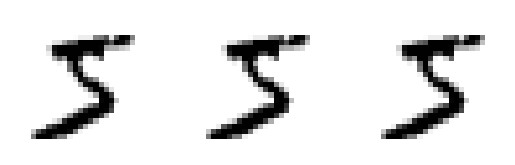

In [141]:
#repeating gray scale image in 3 channel format for compatability with three channel format 
#of the pre-trained network

print('Image shape before:')
print(X.shape)  
X_rgb = np.repeat(X,3,axis=-1)
print('Image shape after:')
print(X_rgb.shape)

print('\nChecking Image:')
#checking repeat image 
for n in range(3):
    ax = plt.subplot(1,3,n+1)
    show_num(X_rgb[0][:,:,n])

In [214]:
#Making test and train sets
X_train, y_train, X_valid, y_valid, X_test, y_test = X_rgb[:60000], y[:60000],X_rgb[60000:65000],y[60000:65000],X_rgb[65000:],y[65000:]
train_data = (X_train, y_train, X_valid, y_valid)

### Building and training transfer learning models

In [223]:
#function for creating transfer learning model

def build(t_model, input_size):
    #creates transfer model
    transfer_model = t_model(include_top=False, input_shape=(input_size,input_size,3),weights='imagenet')
    transfer_model.trainable = False #freezes model 

    #creates rescaling layer to scale input values [0,255] to [-1,1]
    scale_layer = tf.keras.layers.Rescaling(scale=1 / 127.5, offset=-1)

    #print('Transfer model:')
    #print(transfer_model.summary())

    #creates model with fully connected layers
    inputs = tf.keras.Input(shape=(28,28,3), name='Input')
    x = scale_layer(inputs)
    x = tf.keras.layers.Resizing(input_size, input_size)(x)
    x = transfer_model(x)
    x = tf.keras.layers.Flatten()(x)
    x = tf.keras.layers.Dense(units=128, activation='relu', kernel_initializer='he_normal')(x)
    x = tf.keras.layers.Dropout(0.2)(x)
    x = tf.keras.layers.Dense(units=64, activation='relu', kernel_initializer='he_normal')(x)
    x = tf.keras.layers.Dropout(0.2)(x)
    outputs = tf.keras.layers.Dense(units=10,activation='linear',kernel_initializer='he_normal')(x)
        
    model = tf.keras.Model(inputs, outputs)

    print('   ')
    print('Model summary:')
    print(model.summary())

    #Checks that proper layers are frozen
    print('Frozen Layers:')
    for layer in model.layers:
        print(str(layer.name),str(layer.trainable))
    
    #compile model 
    model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
            optimizer = tf.keras.optimizers.Adam(0.001),
            metrics = ['accuracy'])
    

    return(model)

In [217]:
def train(model, train_data, iters, fine_tune):
    #training top layers
    print('Training top layers...')
    history = model.fit(train_data[0], train_data[1], validation_data=(train_data[2:]), epochs = iters[0])
    acc = history_resnet.history['accuracy']
    val_acc = history_resnet.history['val_accuracy']
    loss = history_resnet.history['loss']
    val_loss = history_resnet.history['val_loss']
    
    #weight_file_name = str(transfer_model)+'_t.h5'
    #model.save_weights(weight_file_name)
    
    ##call back to save weights
    #
    #save_weights = ModelCheckpoint(weight_file_name, save_best_only=True, save_weights_only=True)

    #fine tuning all layers
    if fine_tune:
        print('Fine tuning all layers...')
        print('Unfreezing transfer model:')
        model.layers[2].trainable = True 
        print(str(model.layers[2].name),str(model.layers[2].trainable))

        print('Freezing batch normalization layers in transfer model:')
        for layer in model.layers[2].layers:
            if isinstance(layer,tf.keras.layers.BatchNormalization):
                layer.trianable = False
                print(layer.name, layer.training, layer.trainable)

        model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
            optimizer = tf.keras.optimizers.Adam(1e-6),
            metrics = ['accuracy'])

        model.fit(train_data[0], train_data[1], validation_data = (train_data[2:]), epochs = iters[1])
        history += model.fit(X_train, y_train, epochs = iters[0])
        acc += history_resnet.history['accuracy']
        val_acc += history_resnet.history['val_accuracy']
        loss += history_resnet.history['loss']
        val_loss += history_resnet.history['val_loss']

        return(model, history)
    else: return(model, history)

In [224]:
t_resnet = build(ResNet50, 32)
train(t_resnet, train_data, iters, True)

   
Model summary:
Model: "model_49"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 28, 28, 3)]       0         
                                                                 
 rescaling_8 (Rescaling)     (None, 28, 28, 3)         0         
                                                                 
 resizing_66 (Resizing)      (None, 32, 32, 3)         0         
                                                                 
 resnet50 (Functional)       (None, 1, 1, 2048)        23587712  
                                                                 
 flatten_29 (Flatten)        (None, 2048)              0         
                                                                 
 dense_156 (Dense)           (None, 128)               262272    
                                                                 
 dropout_99 (Dropout)        (None, 128

KeyboardInterrupt: 

### ResNet50

In [47]:
#load Resnet 50
Resnet_50 = ResNet50(include_top=False, input_shape=(32,32,3),weights='imagenet')
Resnet_50.trainable = False #freezes model 
Resnet_50.summary()

Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 32, 32, 3)]  0           []                               
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 38, 38, 3)    0           ['input_4[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 16, 16, 64)   9472        ['conv1_pad[0][0]']              
                                                                                                  
 conv1_bn (BatchNormalization)  (None, 16, 16, 64)   256         ['conv1_conv[0][0]']             
                                                                                           

In [81]:
#create a new model on top 
inputs = tf.keras.Input(shape=(28,28,3), name='Input')
x = tf.keras.layers.Resizing(32,32)(inputs)
x = Resnet_50(x)
outputs = top_model(x)
model = tf.keras.Model(inputs, outputs)
model.summary()

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 28, 28, 3)]       0         
                                                                 
 resizing_14 (Resizing)      (None, 32, 32, 3)         0         
                                                                 
 resnet50 (Functional)       (None, 1, 1, 2048)        23587712  
                                                                 
 Fully_Connected_Layers (Seq  (None, 10)               271178    
 uential)                                                        
                                                                 
Total params: 23,858,890
Trainable params: 271,178
Non-trainable params: 23,587,712
_________________________________________________________________


In [84]:
build_and_train.build(Resnet_50, 32, top_model)

AttributeError: 'KerasTensor' object has no attribute 'lower'

In [49]:
model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
               optimizer = tf.keras.optimizers.Adam(0.001),
               metrics = ['accuracy'])

In [50]:
save_weights = ModelCheckpoint('weights_Resnet50_t.h5', save_best_only=True, save_weights_only=True)

In [53]:
#just training the top layers
#model.load_weights('weights_Resnet50_t.h5')

history_resnet = model.fit(X_train, y_train, epochs=fc_iter, validation_data=(X_valid, y_valid),callbacks=[save_weights])
acc = history_resnet.history['accuracy']
val_acc = history_resnet.history['val_accuracy']
loss = history_resnet.history['loss']
val_loss = history_resnet.history['val_loss']

model.save_weights('weights_Resnet50_t.h5')

1875/1875 [==============================] - 179s 94ms/step - loss: 0.8599 - accuracy: 0.7117 - val_loss: 0.4949 - val_accuracy: 0.8488


In [ ]:
history_resnet = model.fit(X_train[:5000], y_train[:5000], epochs=ft_iter, validation_data=(X_valid, y_valid),callbacks=[save_weights])
acc += history_resnet.history['accuracy']
val_acc += history_resnet.history['val_accuracy']
loss += history_resnet.history['loss']
val_loss += history_resnet.history['val_loss']

In [ ]:
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
#plt.ylim([0.8, 1])
plt.plot([fc_iter-1,fc_iter-1],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
#plt.ylim([0, 1.0])
plt.plot([fc_iter-1,fc_iter-1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [ ]:
y_pred = model.predict(X_test).argmax(axis=1)
resnet_score = accuracy_score(y_test,y_pred)

### Inception V3

In [ ]:
#load Inception V3
inception_V3 = InceptionV3(include_top=False, input_shape=(75,75,3),weights='imagenet')
inception_V3.trainable = False #freezes model 
inception_V3.summary()

In [ ]:
top_model = tf.keras.Sequential([
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(units=128, activation='relu', kernel_initializer='he_normal'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(units=64, activation='relu', kernel_initializer='he_normal'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(units=10,activation='linear',kernel_initializer='he_normal')
],name='Fully_Connected_Layers')

In [ ]:
#add fully connected layers
inputs_inception = tf.keras.Input(shape=(28,28,3), name='Input')
xx = tf.keras.layers.Resizing(75,75)(inputs_inception)
xx = inception_V3(xx)
outputs_inception = top_model(xx)

model_inception = tf.keras.Model(inputs_inception, outputs_inception)
model_inception.summary()

In [ ]:
save_weights_inception = ModelCheckpoint('weights_inceptionV3_t.h5', save_best_only=True, save_weights_only=True)

In [ ]:
model_inception.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
               optimizer = tf.keras.optimizers.Adam(0.001),
               metrics = ['accuracy'])

In [ ]:
#just training the top layers
#model_inception.load_weights('weights_inceptionV3_t.h5')
model_inception.fit(X_train, y_train, epochs=fc_iter, validation_data=(X_valid, y_valid),callbacks=[save_weights_inception])
model_inception.save_weights('weights_inceptionV3_t.h5')

In [ ]:
#fine tuning the whole model 
#model_inception.load_weights('weights_inceptionV3_t.h5')
inception_V3.trainable = True #unfreezes base model

for layer in inception_V3.layers: #freezes batch normalization layers
    if (isinstance(layer, tf.keras.layers.BatchNormalization)):
        layer.trainable = False
        
#check that BN layers are set to training = False
#for layer in inception_V3.layers:
    #if layer.trainable == False:
        #print (layer.name)
        

model_inception.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
               optimizer = tf.keras.optimizers.Adam(1e-5),
               metrics = ['accuracy'])

In [ ]:
model_inception.fit(X_train, y_train, epochs=ft_iter, validation_data=(X_valid, y_valid), callbacks=[save_weights_inception])

In [ ]:
y_pred = model_inception.predict(X_test).argmax(axis=1)
inception_score = accuracy_score(y_test,y_pred)
inception_score

### Mobile Net

In [ ]:
#load mobile net
mobile_net = MobileNet(include_top=False, input_shape=(32,32,3),weights='imagenet')
mobile_net.trainable = False #freezes model 
mobile_net.summary()

In [ ]:
top_model = tf.keras.Sequential([
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(units=128, activation='relu', kernel_initializer='he_normal'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(units=64, activation='relu', kernel_initializer='he_normal'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(units=10,activation='linear',kernel_initializer='he_normal')
],name='Fully_Connected_Layers')

In [ ]:
#add fully connected layers
inputs_mobile = tf.keras.Input(shape=(28,28,3), name='Input')
xxx = tf.keras.layers.Resizing(32,32)(inputs_mobile)
xxx = mobile_net(xxx)
outputs_mobile = top_model(xxx)

model_mobile = tf.keras.Model(inputs_mobile, outputs_mobile)
model_mobile.summary()

In [ ]:
save_weights_mobile = ModelCheckpoint('weights_mobilenet_t', save_best_only=True, save_weights_only=True)

In [ ]:
model_mobile.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
               optimizer = tf.keras.optimizers.Adam(0.001),
               metrics = ['accuracy'])

In [ ]:
#just training the top layers
#model.load_weights('weights_mobilenet_t.h5')
model_mobile.fit(X_train, y_train, epochs=fc_iter, validation_data=(X_valid, y_valid),callbacks=[save_weights_mobile])
model_mobile.save_weights('weights_mobilenet_t.h5')

In [ ]:
#fine tuning the whole model 
#model_mobile.load_weights('weights_mobilenet_t.h5')
mobile_net.trainable = True #unfreezes base model

for layer in mobile_net.layers: #freezes batch normalization layers
    if isinstance(layer,tf.keras.layers.BatchNormalization):
        layer.trainable = False
        
model_mobile.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
               optimizer = tf.keras.optimizers.Adam(1e-5),
               metrics = ['accuracy'])

In [ ]:
model_mobile.fit(X_train, y_train, epochs=ft_iter, validation_data=(X_valid, y_valid),callbacks=[save_weights_mobile])

In [ ]:
y_pred = model_mobile.predict(X_test).argmax(axis=1)
mobile_score = accuracy_score(y_test,y_pred)
mobile_score